Title & Description: 
Building A lightweight U-Net for brain tumor segmentation (using BraTS dataset) under limited GPU resources, and comparing performance (Dice score + qualitative results) to the BraTS 2020 nnU-Net winner (DKFZ_MIC).

Imports & Setup

In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Processing Libs 
import skimage as ski
import PIL.Image as Image

# NN libs
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Neural Imaging Libs
import nibabel as nib
import nilearn.plotting as nlplt
import nilearn as nl

#Getting helper scripts
from utils.ablation_loader import BraTSDatasetP1
from utils.ablation_loader import BraTSDatasetP2
from utils.ablation_loader import BraTSDatasetP3
from utils.ablation_loader import get_brats_filepaths
from utils.ablation_loader import build_cache
from utils.ablation_loader import visualize_patient_consistency
from utils.ablation_loader import split_brats_dataset
from utils.metrics import compare_pipelines_dice
# from utils.unet import UNet
# from utils.metrics import dice_score, etc

In [35]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# General Paths
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"
MODELS_PATH = "models/"
RESULTS_PATH = "results/"


Using device: cuda


Loading and Visualizing sample data

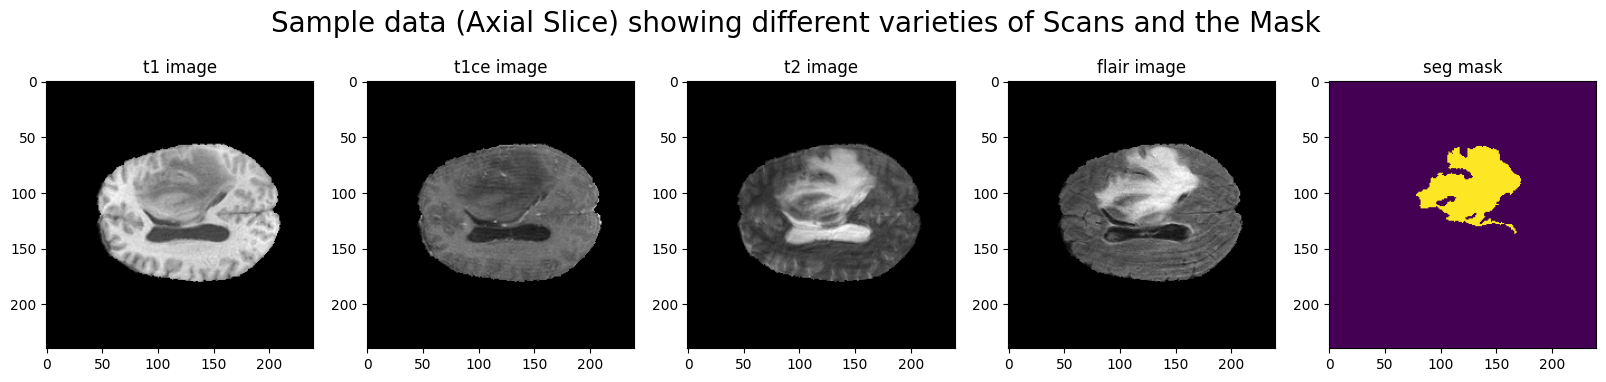

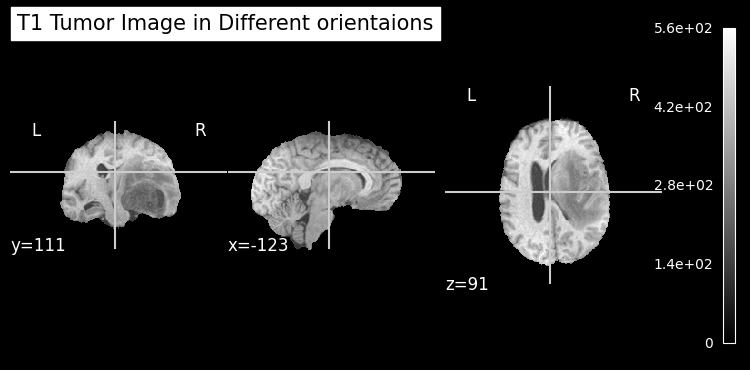

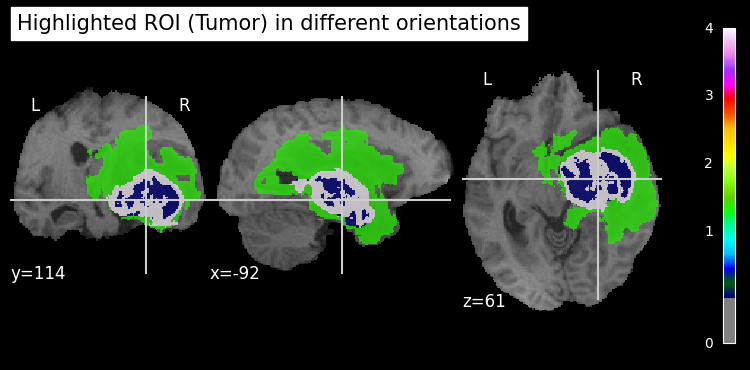

In [38]:
###
Test_filepath = "data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"
# Loading data and extracting image data with "get_fdata()"
test_t1_image = nib.load(Test_filepath + "BraTS20_Training_001_t1.nii").get_fdata()
test_t1ce_image = nib.load(Test_filepath + "BraTS20_Training_001_t1ce.nii").get_fdata()
test_t2_image = nib.load(Test_filepath + "BraTS20_Training_001_t2.nii").get_fdata()
test_flair_image = nib.load(Test_filepath + "BraTS20_Training_001_flair.nii").get_fdata()
test_mask = nib.load(Test_filepath + "BraTS20_Training_001_seg.nii").get_fdata()

volume_show = 89 #Orientation to view 

# Visualizing sample of Image data
 
fig , (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))

fig.suptitle('Sample data (Axial Slice) showing different varieties of Scans and the Mask'
            , y=0.70, fontsize=20 )

ax1.imshow(test_t1_image[:,:,volume_show], cmap = "gray")
ax1.set_title("t1 image")

ax2.imshow(test_t1ce_image[:,:,volume_show], cmap = "gray")
ax2.set_title("t1ce image")

ax3.imshow(test_t2_image[:,:,volume_show], cmap = "gray")
ax3.set_title("t2 image")

ax4.imshow(test_flair_image[:,:,volume_show], cmap = "gray")
ax4.set_title("flair image")

ax5.imshow(test_mask[:,:,volume_show])
ax5.set_title("seg mask")

nl_test_t1_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_t1.nii")
nl_test_mask_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_seg.nii")

nlplt.plot_epi(nl_test_t1_image, title="T1 Tumor Image in Different orientaions")
nlplt.plot_roi(nl_test_mask_image,bg_img=nl_test_t1_image , title="Highlighted ROI (Tumor) in different orientations")

Dataset Preprocessing

In [44]:
#Extract image and mask paths
trainingData_root_dir = os.path.join(RAW_DATA_PATH, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData") #create directory to data
image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 
print(mask_paths[354]) #Test Print

data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_seg.nii


In [46]:
#  Performing Patientwise split 
train_imgs, val_imgs, train_masks, val_masks = split_brats_dataset(
    image_paths, mask_paths, val_size=0.2, seed=42
)

print(f"Train patients: {len(train_imgs)}")
print(f"Val patients: {len(val_imgs)}")

# Derive patient IDs from the split lists
def pid_from_modalities(modality_paths):
    """
    modality_paths: list of 4 paths [flair, t1, t1ce, t2]
    Returns the patient folder name used in cache (e.g., 'BraTS20_Training_001').
    """
    return os.path.basename(os.path.dirname(modality_paths[0]))

train_pids = [pid_from_modalities(m) for m in train_imgs] #Extracting train patient IDs
val_pids   = [pid_from_modalities(m) for m in val_imgs] #Extracting val patient IDs

# Checking if lengths match
len(train_pids) == len(train_imgs), len(val_pids)  == len(val_imgs)

Train patients: 295
Val patients: 74


(True, True)

DATA preprocessing --> ABLATION STUDIES

We evaluated three different preprocessing pipelines to investigate whether certain preprocessing shortcuts could speed up training without compromising data integrity. The goal was to test if cached volumes or pre-extracted patches (P2, P3) remain comparable to the standard on-the-fly preprocessing approach (P1) in terms of preserving anatomical structures and segmentation quality. These pipelines are built in data_loader.py file

In [62]:
'''
Preparing directories to create Cache (saved image patches and volumes) for P2 and P3 using the split

'''
# Cache directories
cache_root = "data/processed/cache"
cache_train = os.path.join(cache_root, "train")
cache_val   = os.path.join(cache_root, "val")

In [64]:
# # 
'''
Build cache for train and val separately (we execute once and comment out to prevent corrupting the data)

'''
# build_cache(train_imgs, train_masks, out_dir=cache_train, num_patches=8)  # P2 & P3 train
# build_cache(val_imgs, val_masks, out_dir=cache_val, num_patches=8)        # P2 & P3 val

'\nBuild cache for train and val separately (we execute once and comment out to prevent corrupting the data)\n\n'

In [66]:
'''
Creating datasets for each pipeline; P1, P2, P3

'''

# P1 (on the fly)
train_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=True)
val_dataset_P1   = BraTSDatasetP1(val_imgs,   val_masks,   augment=False)

# P2 (cached volumes)
train_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_train, "volumes"),
    patient_ids=train_pids,
    patch_size=(96,96,96),
    augment=True
)
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

# P3 (cached patches)
train_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_train, "patches"),
    patient_ids=train_pids,
    augment=True
)
val_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_val, "patches"),
    patient_ids=val_pids,
    augment=False
)

Plot saved to results/images/patient-9_rand_consistency.png


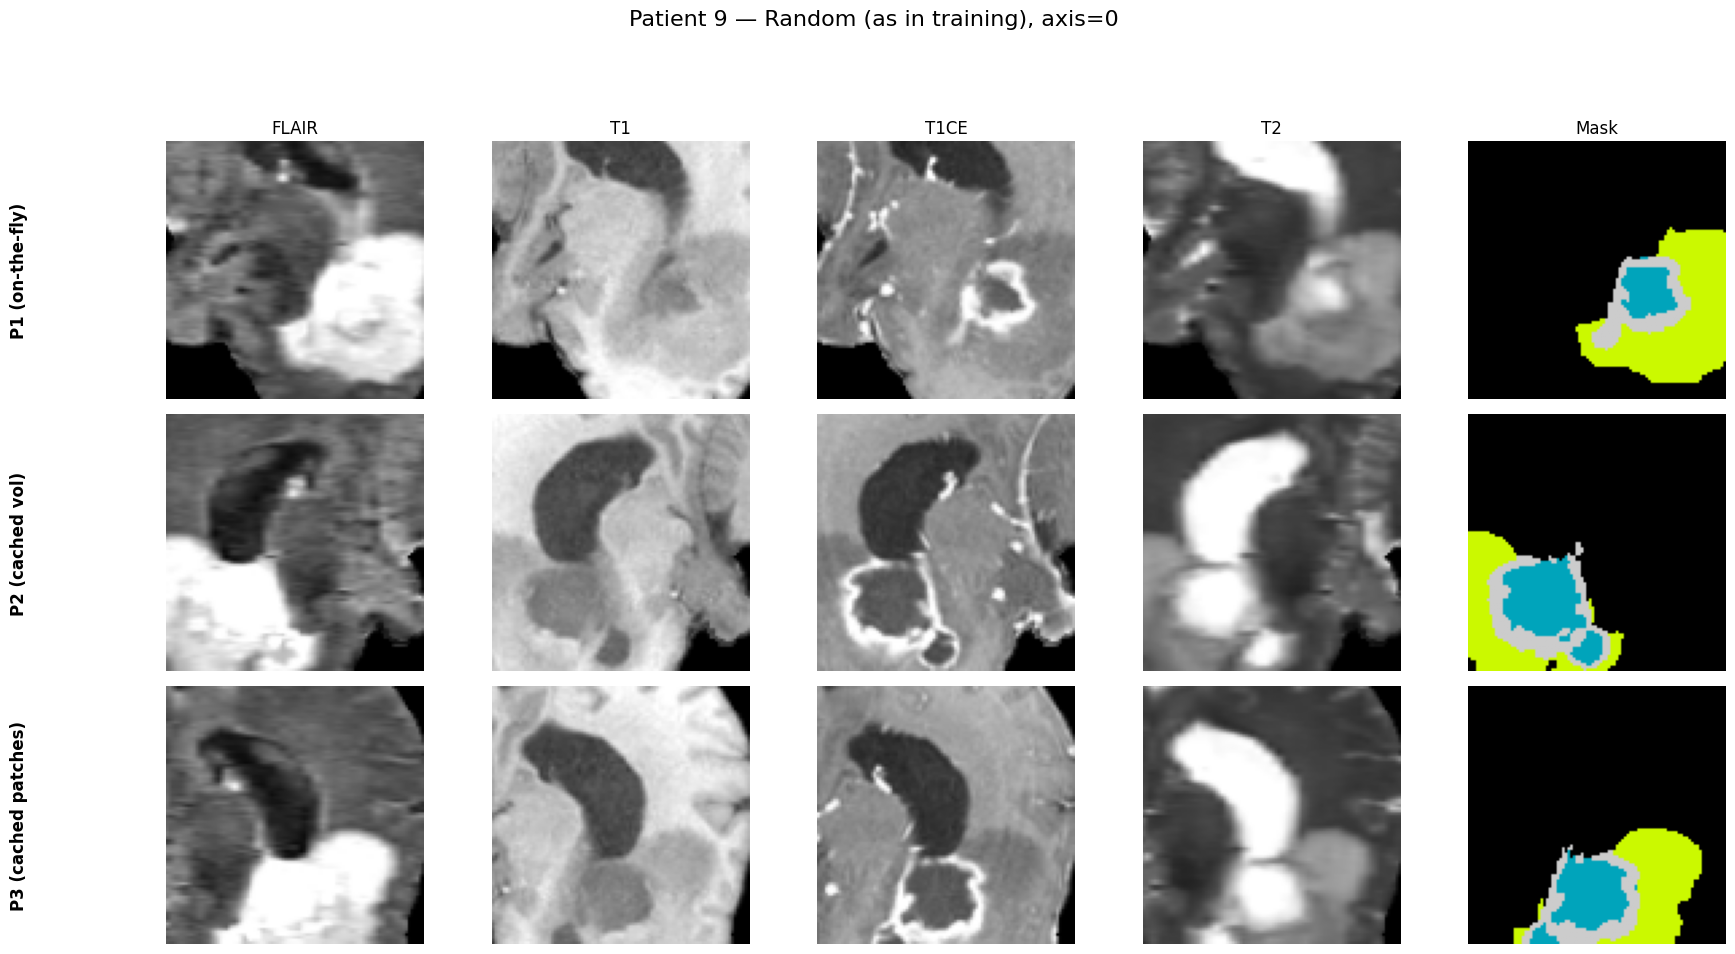

Plot saved to results/images/patient-9_det_consistency.png


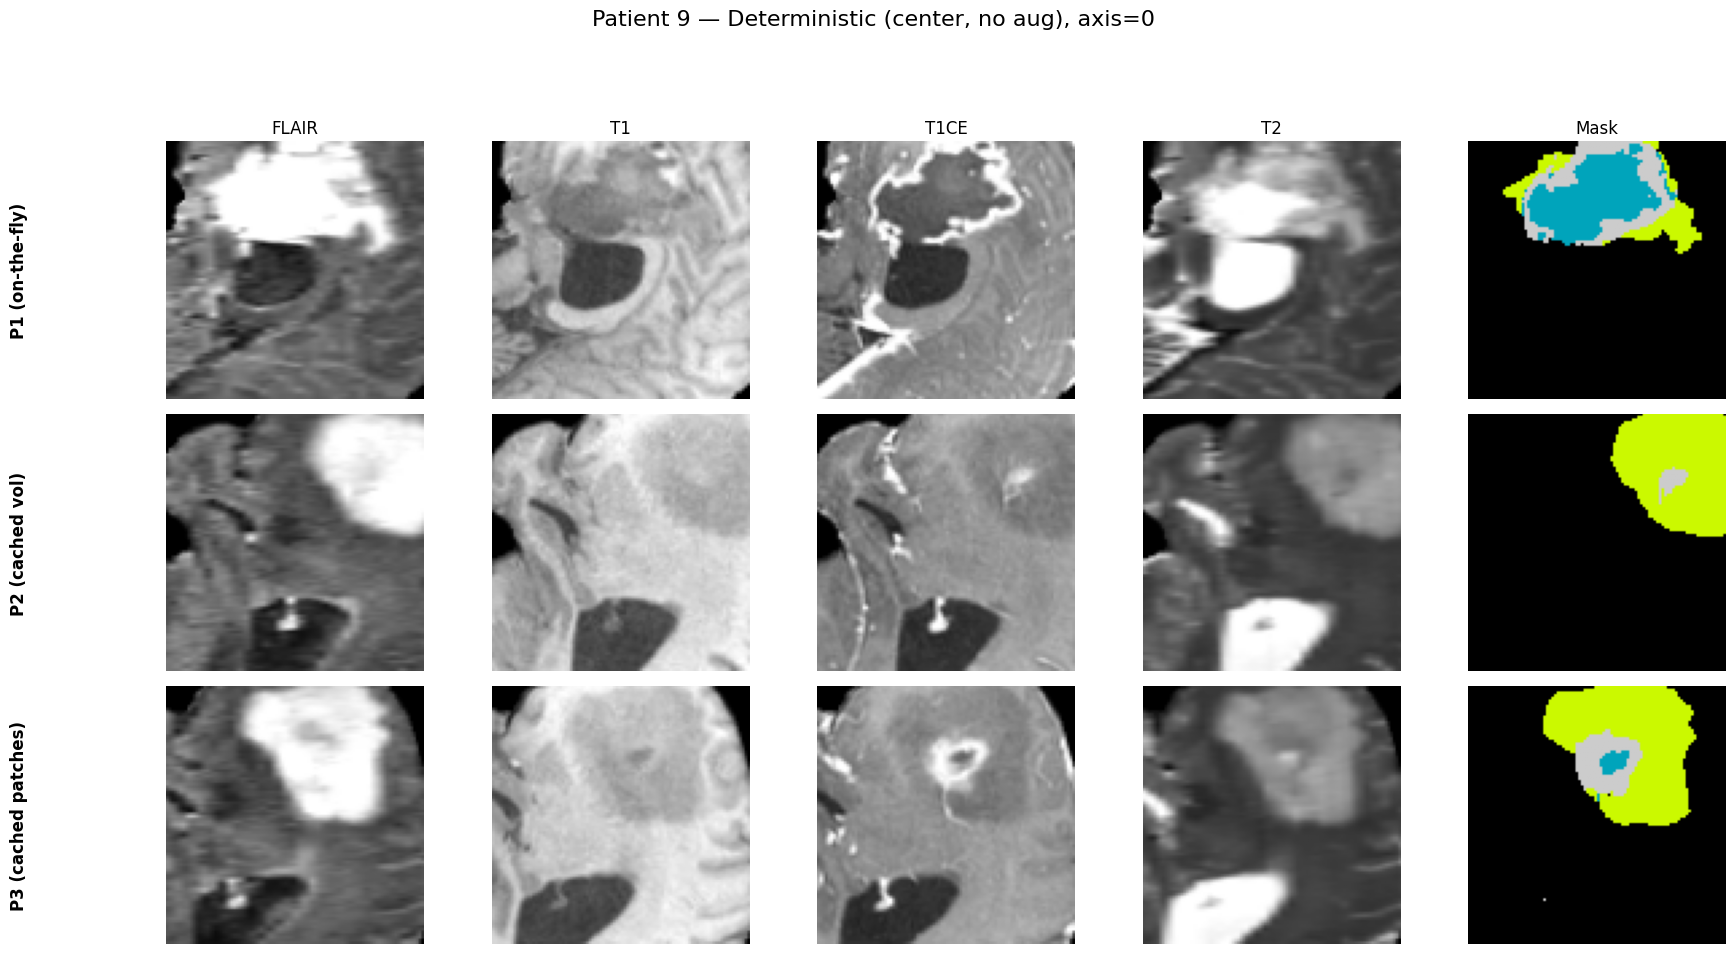

In [68]:
'''
Qualitative Sanity checks: 
Visualizing patches produced by the 3 pipelines -> mainly Checking for consistency of anatomical regions ("what the model sees!")
'''
#What the model really sees after all pipelines have been executed successfully (random patches)
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=False)

#Force centered patches with reversed Augmentations just for sanity check of anatomical regions (Deterministic patches) 
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=True)

In [77]:
# dice scores 
'''
Quantitative Sanity checks: 
Evaluating consistency of tumor regions ("what the model sees!") across preprocessing pipelines, by computing 
Dice similarity coefficients between segmentation masks from the cached pipelines (P2, P3) and the on-the-fly reference (P1). 
Results are summarized as mean ± standard deviation across sampled patches

'''

results = compare_pipelines_dice(train_dataset_P1, train_dataset_P2, train_dataset_P3, num_samples=20)

regions = ["Whole Tumor", "Tumor Core", "Enhancing Tumor", "All Classes"]

# Print P2 vs P1
print("Dice Scores (P2 vs P1):")
for i, region in enumerate(regions):
    mean = results["P2_vs_P1"][0][i]
    std = results["P2_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")

# Print P3 vs P1
print("\nDice Scores (P3 vs P1):")
for i, region in enumerate(regions):
    mean = results["P3_vs_P1"][0][i]
    std = results["P3_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")

Dice Scores (P2 vs P1):
  Whole Tumor    : 0.807 ± 0.056
  Tumor Core     : 0.182 ± 0.186
  Enhancing Tumor: 0.264 ± 0.172
  All Classes    : 0.309 ± 0.318

Dice Scores (P3 vs P1):
  Whole Tumor    : 0.796 ± 0.080
  Tumor Core     : 0.151 ± 0.162
  Enhancing Tumor: 0.244 ± 0.221
  All Classes    : 0.306 ± 0.334


In [81]:
'''
Hyperparameters to adjust

'''

batch_size = 2

In [85]:
'''
Preparing data for both training and validation (for all three pipelines : P1, P2, P3)

'''


#  DataLoaders
train_loader_P1 = DataLoader(train_dataset_P1, batch_size=batch_size, shuffle=True)
val_loader_P1   = DataLoader(val_dataset_P1,   batch_size=batch_size, shuffle=False)

train_loader_P2 = DataLoader(train_dataset_P2, batch_size=batch_size, shuffle=True)
val_loader_P2   = DataLoader(val_dataset_P2,   batch_size=batch_size, shuffle=False)

train_loader_P3 = DataLoader(train_dataset_P3, batch_size=batch_size, shuffle=True)
val_loader_P3   = DataLoader(val_dataset_P3,   batch_size=batch_size, shuffle=False)


def train_loader_printout(train_loader):
    for img, mask in train_loader:
        print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
        print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
        break


# Fetch a batch (example print)
train_loader_printout(train_loader_P1), train_loader_printout(train_loader_P2), train_loader_printout(train_loader_P3)

Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])
Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])
Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])


(None, None, None)

Baseline U-Net Setup

Training Loop (Baseline)

Evaluation (Baseline)

Optimized U-Net Setup

Training Loop (Optimized)

Evaluation (Optimized)

Comparison & Visualization

Conclusion